In this notebook, we'll use cassava and discrimination to plot a histogram of comparative covid fatalities rates between counties that voted Democrat or Republican in 2016. 

First we import some libraries

In [1]:
{-# LANGUAGE OverloadedStrings #-}
{-# LANGUAGE DuplicateRecordFields #-}
{-# LANGUAGE RecordWildCards #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE OverloadedStrings #-}
Why not:
Line 3: Unused LANGUAGE pragma
Found:
{-# LANGUAGE RecordWildCards #-}
Why not:

In [2]:
-- base
import Control.Exception (IOException)
import qualified Control.Exception as Exception
import qualified Data.Foldable as F
import Control.Monad (mzero, liftM2, join)

In [3]:
-- logical
import Data.Maybe (fromMaybe)
import Data.Either (fromRight)

In [4]:
-- casava
import Data.Csv (FromField, parseField, FromNamedRecord, parseNamedRecord, decodeByName, (.:))

In [5]:
-- text
import Data.Text (Text)

-- bytestring
import Data.ByteString.Char8 as Char8
import Data.ByteString.Lazy (ByteString)
import qualified Data.ByteString.Lazy as ByteString

In [6]:
-- time
import Data.Time (UTCTime, parseTime, defaultTimeLocale)

In [7]:
-- vector
import Data.Vector (Vector)
import qualified Data.Vector as Vector

In [8]:
-- for merges and joins
import Data.Discrimination (grouping, inner)

In [9]:
-- for aggregation
import qualified Control.Foldl as FL
import Data.Map.Strict (Map, (!?))
import qualified Data.Map.Strict as Map

In [10]:
-- plotting
import qualified Graphics.Rendering.Chart.Easy as CH
import qualified Graphics.Rendering.Chart.Backend.Cairo as Cairo

Next we will need to load our data from CSV files. We'll do this using Cassava.

The structure of the [NYT County-Level Covid Data Set]( https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv) is described in the following record. Note that [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a code assigned to each county. Some records are missing the FIPS code, which we indicate using Maybe's Nothing value.

In [11]:
-- Describe the record to hold a datum from the county-level covid database
data CovidRec = CovidRec {
        date :: UTCTime,
        county :: Text,
        state :: Text,
        mFips :: Maybe Int,
        cases :: Int,
        deaths :: Int
    } deriving (Show, Eq)

Cassava will parse most of these datatypes for us, except for the date field. We'll have to tell it how to do that:

In [12]:
-- We'll need a custom parser for the dates:
parseDate d = parseTime defaultTimeLocale "%Y-%m-%d" (Char8.unpack d) :: Maybe UTCTime
instance FromField UTCTime where
  parseField dateData = case maybeDate of 
          Just date -> pure date
          Nothing -> mzero
      where maybeDate = parseDate dateData

Next we tell Cassava how to match column names (in the CSV file) to the record fields:

In [13]:
-- setup the parser
instance FromNamedRecord CovidRec where
  parseNamedRecord m =
    CovidRec
      <$> m .: "date"
      -- Note that .: is an alias to @lookup@ a key ("date") in the Map.
      <*> m .: "county"
      <*> m .: "state"
      <*> m .: "fips"
      <*> m .: "cases"
      <*> m .: "deaths"

We'll need the following helper function to deal with IO failures:

In [14]:
catchShowIO :: IO a -> IO (Either String a)
catchShowIO action =
  fmap Right action `Exception.catch` handleIOException
  where
    handleIOException :: IOException -> IO (Either String a)
    handleIOException = return . Left . show

In [15]:
decodeRecs :: FromNamedRecord a => ByteString.ByteString -> Either String (Vector a)
decodeRecs = fmap snd . decodeByName

decodeRecsFromFile :: FromNamedRecord a => FilePath -> IO (Either String (Vector a))
decodeRecsFromFile filePath =
  either Left decodeRecs <$>
  catchShowIO (ByteString.readFile filePath)

Ok, having set that up, let's load the data:

In [16]:
covidRecs <- decodeRecsFromFile "us-counties.csv" :: IO (Either String (Vector CovidRec))

Take a look at an example record (at row 23):

In [17]:
 either id (show . (Vector.! 23)) covidRecs

"CovidRec {date = 2020-01-29 00:00:00 UTC, county = \"Maricopa\", state = \"Arizona\", mFips = Just 4013, cases = 1, deaths = 0}"

Next we need to load census data, which will have the following record structure:

In [18]:
-- Describe the record to hold a census datum
data CensusRec = CensusRec {
        fips :: Int,
        stateId :: Int,
        countyId :: Int,
        population :: Int,
        stateName :: Text,
        countyName :: Text
    } deriving (Show, Eq)

Setting up the parser is fairly straightforward here:

In [19]:
-- setup the parser
instance FromNamedRecord CensusRec where
  parseNamedRecord m =
    CensusRec
      <$> m .: "fips"
      <*> m .: "state"
      <*> m .: "county"
      <*> m .: "popestimate2019"
      <*> m .: "stname"
      <*> m .: "ctyname"

Great, now load the data:

In [20]:
censusRecs <- decodeRecsFromFile "fips-pop.csv" :: IO (Either String (Vector CensusRec))

We want to join the covid and census data on their FIPS field. We can do that using discrimination's inner function:

```haskell
inner :: Discriminating f	 
    => f d  -- the discriminator to use (just use discrimination provided grouping function)
    -> (a -> b -> c)  --how to join two rows
    -> (a -> d)	 -- selector for the left table
    -> (b -> d)	 -- selector for the right table
    -> [a] -- left table
    -> [b]  -- right table
    -> [[c]]	 
```
We'll want to retain just the cases, deaths, date, fips, and poputation fields:

In [21]:
data CovCensRec = CovCensRec {
        date :: UTCTime,
        fips :: Int,
        county :: Text,
        cases :: Int,
        deaths :: Int,
        population :: Int
    } deriving (Show, Eq)

mergeCovCensRec :: CovidRec -> CensusRec -> CovCensRec
mergeCovCensRec CovidRec{..} CensusRec{..} = CovCensRec{..}

In [22]:
joinCovCensusRecs :: Vector CovidRec -> Vector CensusRec -> [CovCensRec]
joinCovCensusRecs l r = F.concat $ 
    inner grouping mergeCovCensRec (fromMaybe (-1) . mFips) csFips (F.toList l) (F.toList r)
    where csFips = fips :: CensusRec -> Int

In [23]:
covCensusRecs = joinCovCensusRecs <$> covidRecs <*> censusRecs

Let's look at an example of such a row for alameda:

In [24]:
do
    let countyNm = county :: CovCensRec -> Text
    print $ either id (show . Prelude.head . Prelude.filter ((== "Alameda") . countyNm)) covCensusRecs

"CovCensRec {date = 2020-03-01 00:00:00 UTC, fips = 6001, county = \"Alameda\", cases = 1, deaths = 0, population = 1671329}"

Finally, we load the voting data from the 2016 election. This is structured according to the following record type:

In [25]:
data VotesRec = VotesRec {
        demVotes :: Int,
        gopVotes :: Int,
        stateAbbr :: Text,
        countyName :: Text,
        fips :: Int
    } deriving (Show, Eq)

In [26]:
-- setup the parser
instance FromNamedRecord VotesRec where
  parseNamedRecord m =
    VotesRec
      <$> m .: "votes_dem"
      <*> m .: "votes_gop"
      <*> m .: "state_abbr"
      <*> m .: "county_name"
      <*> m .: "combined_fips"

In [27]:
votesRecs <- decodeRecsFromFile "us-election-data-2016.csv" :: IO (Either String (Vector VotesRec))

Now we want to join this along fips to form the final record:

In [28]:
data CountyRec = CountyRec {
        date :: UTCTime,
        county :: Text,
        cases :: Int,
        deaths :: Int,
        population :: Int,
        demVotes :: Int,
        gopVotes :: Int
    } deriving (Show, Eq)

mergeCovCensVotesRec :: CovCensRec -> VotesRec -> CountyRec
mergeCovCensVotesRec CovCensRec{date=d, county=c, cases=cs, deaths=ds, population=p} VotesRec{demVotes=dv, gopVotes=gv} 
    = CountyRec d c cs ds p dv gv

In [29]:
joinCountyRecs :: [CovCensRec] -> Vector VotesRec -> [CountyRec]
joinCountyRecs l r = F.concat $ 
    inner grouping mergeCovCensVotesRec cFips vFips l (F.toList r)
    where 
        cFips = fips :: CovCensRec -> Int
        vFips = fips :: VotesRec -> Int

In [30]:
countyRecs = joinCountyRecs <$> covCensusRecs <*> votesRecs

Let's examine an example row for alameda:

In [31]:
do
    let countyNm = county :: CountyRec -> Text
    print $ either id (show . Prelude.head . Prelude.filter ((== "Alameda") . countyNm)) countyRecs

"CountyRec {date = 2020-03-01 00:00:00 UTC, county = \"Alameda\", cases = 1, deaths = 0, population = 1671329, demVotes = 486351, gopVotes = 91189}"

Finally, let's compute the county by country fatality rates, separately for democratic and gop counties.

We'll start by building a fold which computes the fatality rate for a `CountyRec`.

In [32]:
-- fatality rate:
fatalityRateFold :: FL.Fold CountyRec (Maybe Double)
fatalityRateFold = liftM2 (/) 
    <$> FL.premap (fromIntegral . (deaths :: CountyRec -> Int)) FL.maximum 
    <*> FL.premap (fromIntegral . (population :: CountyRec -> Int)) FL.maximum

Next, we use `Foldl`'s groupBy to lift that fold so as to group over counties. We accept a predicate function to allow us to aggregate democratic and gop counties separately.

In [33]:
-- This is the core group by fold.
fatalitiesByCountyFold :: FL.Fold CountyRec (Map Text (Maybe Double))
fatalitiesByCountyFold = FL.groupBy (county :: CountyRec -> Text) fatalityRateFold

-- Here we lift apply that fold, first filtering by a predicate, and then handling 
-- possible errors (by returning an empty map):
fatalitiesByCounty :: (CountyRec -> Bool) -> Map Text Double
fatalitiesByCounty predicate = case countyRecs of
    -- just get an empty map if there was an error.
    Left s -> Map.empty
    -- apply the fold, dropping any Nothing values from the Map via @Map.mapMaybe id@
    Right r -> Map.mapMaybe id $ FL.fold (FL.prefilter predicate fatalitiesByCountyFold) r

Now we define predicates which determine if a county voted democrat or gop during the 2016 election

In [34]:
isDem :: CountyRec -> Bool
isDem CountyRec{demVotes=d, gopVotes=g} = d > g 

isGop :: CountyRec -> Bool
isGop CountyRec{demVotes=d, gopVotes=g} = d <= g 

And finally, we extract the actual maps for democrat and gop counties:

In [35]:
demFatalities :: Map Text Double
demFatalities = fatalitiesByCounty isDem

In [36]:
gopFatalities :: Map Text Double
gopFatalities = fatalitiesByCounty isGop

For example, lets check the fatality rate in Alameda and San Francisco

In [37]:
demFatalities !? "Alameda"

Just 5.2652709310973486e-5

In [38]:
demFatalities !? "San Francisco"

Just 4.1971575034399676e-5

In [39]:
demHist = CH.histToPlot $ CH.defaultNormedPlotHist
          CH.& CH.plot_hist_bins CH..~ 30
          CH.& CH.plot_hist_values CH..~ Map.elems demFatalities

In [40]:
gopHist = CH.histToPlot $ CH.defaultNormedPlotHist
          CH.& CH.plot_hist_bins CH..~ 30
          CH.& CH.plot_hist_values CH..~ Map.elems gopFatalities

In [41]:
chart = CH.toRenderable
    $ CH.layout_title CH..~ "Beta Distribution"
    $ CH.layout_plots CH..~ [demHist, gopHist]
    $ CH.def

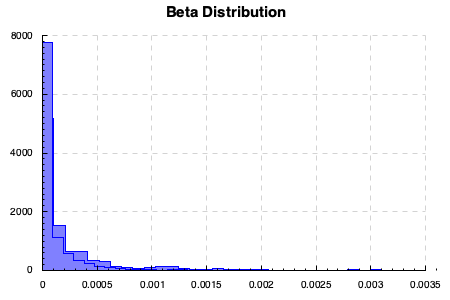

In [43]:
chart

Save the graph as a file.

In [44]:
Cairo.renderableToFile CH.def "covidFatalityRates.png" chart